In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn as sk
import joblib
import random
import gc
import matplotlib.pyplot as plt

2025-07-05 16:07:16.668147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [3]:
df = pd.read_hdf("./dataset.h5", key="df")
df

,Cens_C,Cens_Db,Cens_D,Cens_Eb,Cens_E,Cens_F,Cens_Gb,Cens_G,Cens_Ab,Cens_A,Cens_Bb,Cens_B,chord
0,0.458163,0.228498,0.335618,0.385245,0.280831,0.562060,0.101404,0.142517,0.211683,0.000000,0.081103,0.007991,FMin7
1,0.456882,0.228481,0.329903,0.386718,0.270461,0.563033,0.104248,0.142325,0.223759,0.000000,0.096144,0.008832,FMin7
2,0.454308,0.229081,0.324611,0.388377,0.260669,0.563478,0.107217,0.142526,0.235052,0.000000,0.110957,0.009594,FMin7
3,0.450574,0.230340,0.319815,0.390179,0.251621,0.563336,0.110333,0.143008,0.245606,0.000000,0.125269,0.010269,FMin7
4,0.445894,0.232287,0.315578,0.392097,0.243367,0.562581,0.113524,0.143594,0.255459,0.000000,0.138864,0.010856,FMin7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,0.490536,0.235216,0.519492,0.137961,0.188265,0.078017,0.327002,0.024591,0.219295,0.340838,0.000000,0.319088,D7
1194,0.477874,0.256360,0.501453,0.154785,0.191382,0.085957,0.332729,0.029796,0.262134,0.325269,0.000000,0.316821,D7
1195,0.461399,0.277389,0.479605,0.172138,0.193952,0.093884,0.337396,0.035385,0.308792,0.307975,0.000000,0.314314,D7
1196,0.440879,0.297556,0.453802,0.189563,0.195533,0.101496,0.340624,0.041261,0.358308,0.288795,0.000000,0.311715,D7


In [4]:
print("Chords")
print(df["chord"].value_counts())

Chords
chord
CMin7     11630
AbMin7    11611
GbMin7    11600
DbMin7    11514
FMin7     11264
EMin7     11163
AMin7     11118
DMin7     11039
BbMin7    11026
EbMin7    10884
GMin7     10876
BMin7     10825
AMaj7      6860
EMaj7      6518
GbMaj7     6493
CMaj7      6406
AbMaj7     6379
FMaj7      6278
BbMaj7     6270
GMaj7      6249
DbMaj7     6240
DMaj7      6212
EbMaj7     6185
BMaj7      6135
G7         2692
B7         2536
Db7        2428
Bb7        2427
Ab7        2426
C7         2400
D7         2399
Eb7        2389
A7         2384
Gb7        2359
E7         2345
F7         2340
Name: count, dtype: int64


In [5]:
y = df["chord"]
X = df.drop(columns="chord")
encoder = sk.preprocessing.LabelEncoder()
y_encoded = encoder.fit_transform(y)

joblib.dump(encoder, "./encoder.xz")

['./encoder.xz']

In [6]:
del df
gc.collect()

20

# LSTM

In [7]:
SEQUENCE_LEN = 20 # 0.1 * 20.0 = 2 sec of sequence data

X_seq, y_encoded_seq = None, None
X_seq_list = []
y_encoded_seq_list = []
for i in range(len(X) - SEQUENCE_LEN + 1):
    X_seq_list.append(X.values[i : i + SEQUENCE_LEN, :])
    y_encoded_seq_list.append(y_encoded[i + SEQUENCE_LEN - 1])

X_seq, y_encoded_seq = np.array(X_seq_list), np.array(y_encoded_seq_list)

print("X sequence shape: ", X_seq.shape)
print("y sequence shape: ", y_encoded_seq.shape)

del X_seq_list
del y_encoded_seq_list
gc.collect()

X sequence shape:  (239881, 20, 12)
y sequence shape:  (239881,)


0

In [8]:
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)
_, unique_idx = np.unique(X_seq_flat, axis=0, return_index=True)
unique_idx = np.sort(unique_idx)

X_seq = X_seq[unique_idx]
y_encoded_seq = y_encoded_seq[unique_idx]

print("X deduplicate shape: ", X_seq.shape)
print("y deuplicate shape:  ", y_encoded_seq.shape)

del X_seq_flat
gc.collect()

X deduplicate shape:  (239881, 20, 12)
y deuplicate shape:   (239881,)


0

In [9]:
X_seq_train, X_seq_test, y_seq_train, y_seq_test = sk.model_selection.train_test_split(
    X_seq,
    y_encoded_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_seq,
)

print(f"X_train: {len(X_seq_train)}")
print(f"y_train: {len(y_seq_train)}")
print(f"X_test:  {len(X_seq_test)}")
print(f"y_test:  {len(y_seq_test)}")

del X_seq
del y_encoded_seq
gc.collect()

X_train: 191904
y_train: 191904
X_test:  47977
y_test:  47977


0

In [10]:
print("Total feature: ", X_seq_train.shape[2])
print("Total class:   ", len(encoder.classes_))

Total feature:  12
Total class:    36


In [11]:
class_weights = sk.utils.class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_seq_train),
    y=y_seq_train,
)
class_weight_dict = dict(enumerate(class_weights))

In [12]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(SEQUENCE_LEN, X_seq_train.shape[2]))),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax'),
])

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_lstm.summary()

/usr/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

history = model_lstm.fit(
    X_seq_train,
    y_seq_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
)

Epoch 1/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.4101 - loss: 2.1201 - val_accuracy: 0.6314 - val_loss: 1.2869
Epoch 2/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.6059 - loss: 1.3054 - val_accuracy: 0.6780 - val_loss: 1.1117
Epoch 3/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.6516 - loss: 1.1237 - val_accuracy: 0.7039 - val_loss: 1.0119
Epoch 4/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.6784 - loss: 1.0090 - val_accuracy: 0.7227 - val_loss: 0.9425
Epoch 5/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.6982 - loss: 0.9312 - val_accuracy: 0.7507 - val_loss: 0.8462
Epoch 6/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy: 0.7160 - loss: 0.8698 - val_accuracy: 0.7576 - val_loss: 0.8126
Epoch 7/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.7283 - loss: 0.8185 - val_accuracy: 0.7639 - val_loss: 0.7936
Epoch 8/500
4798/4798 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.7378 -

In [14]:
model_lstm.evaluate(X_seq_test, y_seq_test)
y_pred = np.argmax(model_lstm.predict(X_seq_test), axis=1)
print(
  sk.metrics.classification_report(y_seq_test, y_pred, target_names=encoder.classes_)
)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9138 - loss: 0.2859
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
              precision    recall  f1-score   support

          A7       0.83      0.97      0.89       477
       AMaj7       0.91      0.92      0.91      1372
       AMin7       0.91      0.88      0.90      2224
         Ab7       0.86      0.96      0.91       485
      AbMaj7       0.89      0.94      0.91      1276
      AbMin7       0.94      0.88      0.91      2322
          B7       0.83      0.98      0.90       507
       BMaj7       0.89      0.93      0.91      1227
       BMin7       0.93      0.89      0.91      2165
         Bb7       0.86      0.97      0.92       485
      BbMaj7       0.85      0.95      0.90      1254
      BbMin7       0.90      0.91      0.90      2205
          C7       0.83      0.98      0.90       480
       CMaj7       0.91      0.94      0.92      1281
       CMin7       0.93      0.86      0.90      2326
          D7   

<Figure size 1600x1600 with 0 Axes>

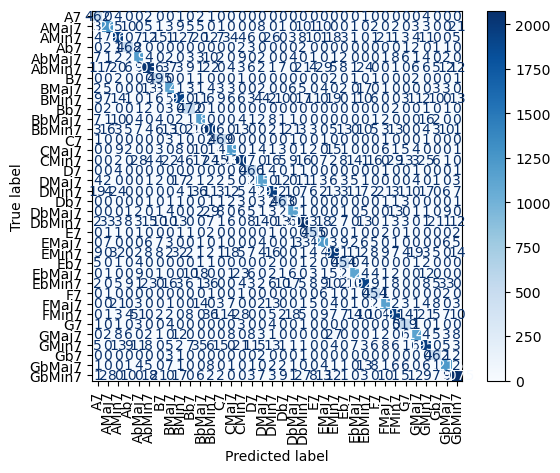

In [24]:
cm = sk.metrics.confusion_matrix(y_seq_test, y_pred)
disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
plt.figure(figsize=(16, 16))
disp.plot(cmap="Blues", xticks_rotation=90)
plt.show()

In [17]:
model_lstm.save("model_lstm_cens_32_32.keras")
pd.DataFrame(history.history).to_csv("model_lstm_cens_32_32_history.csv", index=False)